In [89]:
import pandas as pd
import numpy as np
import hashlib
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
class SimpleCluster:
    def __init__(self,x):
        self.x = x
        
    def __hash__(self):
        return int(hashlib.md5(''.join(self.x).encode()).hexdigest(), 16)

def get_hash(plist):
    c = SimpleCluster(plist)
    return hash(c)

In [17]:
clusters = []
cluster_dict = {}

with open("Pdam.recipe_clusters.csv","r") as cluster_fi:
    for line in cluster_fi:
        c = line.strip().split(",")
        clusters.append(c)
        cluster_dict[get_hash(c)] = c

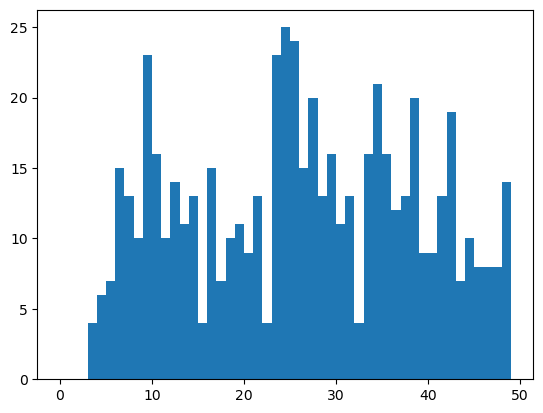

In [77]:
cluster_sizes = [len(c) for c in clusters]
plt.hist(cluster_sizes,bins=np.arange(0,50,1))
plt.show()

In [28]:
counts = pd.read_csv("Connelly2022_AxH_Pdam.counts",sep="\t",skiprows=1)
counts.columns = [i.split("/")[-1].split("_")[0] for i in counts.columns]
counts = counts.set_index("Geneid")
counts = counts.iloc[:,5:]

In [39]:
pearson_corr = counts.T.corr(method="pearson")
spearman_corr = counts.T.corr(method="spearman")

In [123]:
pearson_corr.sort_index().T.sort_index().T

Geneid,pdam_00000001,pdam_00000002,pdam_00000003,pdam_00000004,pdam_00000005,pdam_00000006,pdam_00000007,pdam_00000008,pdam_00000009,pdam_00000010,...,pdam_00026068,pdam_00026069,pdam_00026070,pdam_00026071,pdam_00026072,pdam_00026073,pdam_00026074,pdam_00026075,pdam_00026076,pdam_00026077
Geneid,,,,,,,,,,,,,,,,,,,,,
pdam_00000001,1.000000,0.666573,0.667028,NaN,0.676694,0.812407,0.714853,0.610005,0.300951,-0.421320,...,0.622457,0.194748,0.774458,0.743799,-0.319782,0.650538,-0.294868,0.247626,0.694630,0.487281
pdam_00000002,0.666573,1.000000,0.962175,NaN,0.311082,0.691752,0.305016,0.307877,0.194922,-0.242258,...,0.386075,-0.089369,0.567808,0.522636,-0.329889,0.283986,0.006573,0.013480,0.552773,0.813003
pdam_00000003,0.667028,0.962175,1.000000,NaN,0.400113,0.680981,0.349945,0.415835,0.237952,-0.159112,...,0.307299,-0.136482,0.620925,0.554261,-0.313491,0.277318,0.077255,0.098288,0.581595,0.760035
pdam_00000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdam_00000005,0.676694,0.311082,0.400113,NaN,1.000000,0.571850,0.555103,0.668155,0.444766,-0.091826,...,0.396753,-0.044793,0.514844,0.416418,-0.151539,0.344946,0.005072,0.364155,0.469617,0.163193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pdam_00026073,0.650538,0.283986,0.277318,NaN,0.344946,0.529143,0.612095,0.505017,0.331298,-0.274761,...,0.518233,0.362593,0.568125,0.611663,-0.177102,1.000000,-0.157843,0.197740,0.381029,0.098667
pdam_00026074,-0.294868,0.006573,0.077255,NaN,0.005072,-0.088791,0.019223,0.288647,0.559504,0.789793,...,-0.251497,-0.232450,-0.061393,-0.176949,0.372638,-0.157843,1.000000,0.257260,-0.135187,-0.144314
pdam_00026075,0.247626,0.013480,0.098288,NaN,0.364155,0.349118,0.517376,0.637192,0.631313,0.346332,...,0.153857,0.142941,0.404508,0.110815,0.100356,0.197740,0.257260,1.000000,0.151629,-0.132581


In [47]:
np.savez("connelly2022_correlation.npz",pearson=pearson_corr.values,spearman=spearman_corr.values)

In [86]:
def cluster_correlate(c):
    corr_df = []
    for (pid_a, pid_b) in combinations(c,2):
        try:
            pid_a = pid_a.rstrip("-RA")
            pid_b = pid_b.rstrip("-RA")
            corr_df.append((pid_a, pid_b, pearson_corr.loc[pid_a,pid_b], spearman_corr.loc[pid_a,pid_b]))
        except KeyError:
            continue
    df = pd.DataFrame(corr_df)
    df.columns = ['A','B','pearson','spearman']
    return df

In [87]:
cluster_correlations = {}

for chash, c in cluster_dict.items():
    cluster_correlations[chash] = cluster_correlate(c)

In [98]:
# compute background sample
N_BOOTS = 5000
rng = np.random.default_rng(seed=42)

pearson_sample = []
spearman_sample = []
for _ in tqdm(range(N_BOOTS)):
    boot_size = rng.choice(cluster_sizes)
    rand_list = rng.choice(counts.index, size=boot_size, replace=False)
    corr_df = cluster_correlate(rand_list)
    pearson_sample.append(corr_df.pearson.mean())
    spearman_sample.append(corr_df.spearman.mean())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:23<00:00, 60.08it/s]


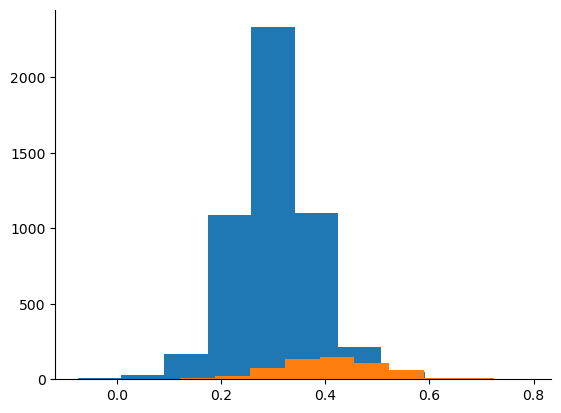

In [124]:
plt.hist(pearson_sample)
plt.hist([c.pearson.mean() for c in cluster_correlations.values()])
sns.despine()
plt.show()

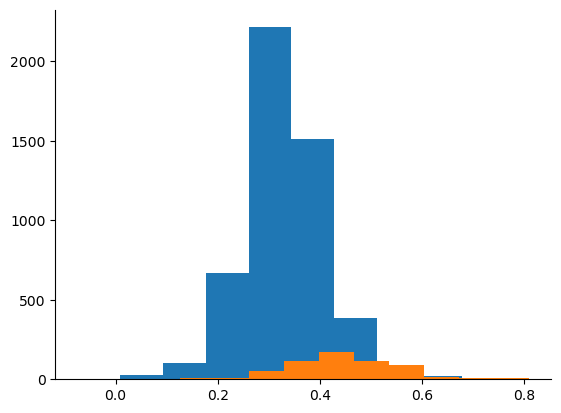

In [125]:
plt.hist(spearman_sample)
plt.hist([c.spearman.mean() for c in cluster_correlations.values()])
sns.despine()
plt.show()

In [111]:
cluster_correlations[143188377126489644]

,A,B,pearson,spearman
0,pdam_00021026,pdam_00014558,0.816033,0.782468
1,pdam_00021026,pdam_00011840,0.652582,0.632419
2,pdam_00021026,pdam_00005044,0.141789,0.132070
3,pdam_00021026,pdam_00019199,0.161066,0.152851
4,pdam_00021026,pdam_00016970,0.176744,0.290321
...,...,...,...,...
61,pdam_00014615,pdam_00017672,0.381564,0.429224
62,pdam_00014615,pdam_00001768,0.152179,0.139813
63,pdam_00009063,pdam_00017672,0.428142,0.444114
64,pdam_00009063,pdam_00001768,0.209875,0.252690


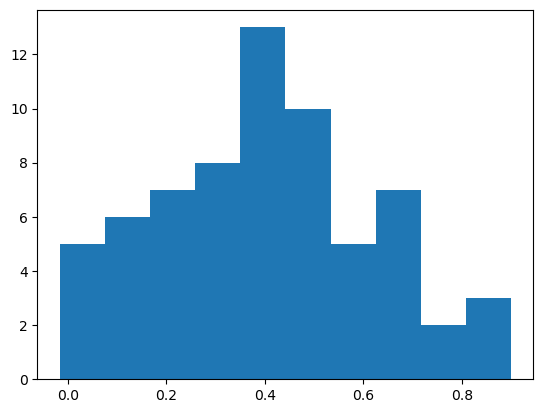

In [112]:
plt.hist(cluster_correlations[143188377126489644].pearson)
plt.show()

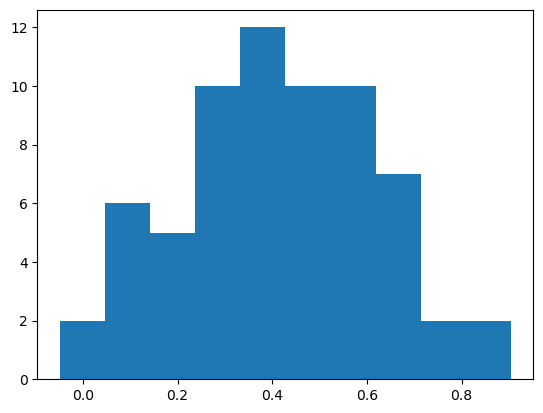

In [119]:
plt.hist(cluster_correlations[143188377126489644].spearman)
plt.show()

In [116]:
cluster_correlations[143188377126489644].pearson.mean()

0.3961635870166049

In [117]:
cluster_correlations[143188377126489644].spearman.mean()

0.40852652991934485